**Deep Convolutional GAN (DCGAN) for Art Portrait Generation.**

This module implements a DCGAN architecture specifically designed for generating
artistic portraits. It includes data preprocessing, model construction, training,
and generation functionality.

`Author: Pourya`

`Date: 2024-11-17`

In [1]:
!mkdir -p /root/.config/kaggle/
!cp /content/drive/MyDrive/kaggle.json /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json

In [2]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('karnikakapoor/art-portraits', path="/content/", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/karnikakapoor/art-portraits


In [1]:
import tensorflow as tf
import numpy as np
from typing import Tuple, Optional, List
import os
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [3]:
class GANConfig:
    """Configuration class for DCGAN implementation.

    This class holds all the hyperparameters and configuration settings for the GAN,
    including model architecture specifications, training parameters, and file paths.

    Attributes:
        noise_dim (int): Dimension of the noise vector input to generator (default: 100)
        image_size (Tuple[int, int]): Target size for generated images (default: (128, 128))
        channels (int): Number of color channels in images (default: 3 for RGB)
        batch_size (int): Number of images per training batch (default: 256)
        epochs (int): Number of training epochs (default: 100)
        steps_per_epoch (int): Number of batches per epoch (default: 8000)
        buffer_size (int): Size of shuffle buffer for dataset (default: 1000)
        learning_rate (float): Learning rate for Adam optimizer (default: 0.0002)
        beta_1 (float): Beta1 parameter for Adam optimizer (default: 0.5)
        data_path (str): Directory path containing training images
        tfrecord_path (str): Path for storing/loading TFRecord dataset
        save_path (str): Directory path for saving model checkpoints
    """
    def __init__(self):
        # Model Architecture
        self.noise_dim: int = 100
        self.image_size: Tuple[int, int] = (128, 128)
        self.channels: int = 3

        # Training Parameters
        self.batch_size: int = 512
        self.epochs: int = 200
        self.steps_per_epoch: int = 8000
        self.buffer_size: int = 1000  # For dataset shuffling

        # Optimizer Configuration
        self.learning_rate: float = 0.0002
        self.beta_1: float = 0.5

        # Paths
        self.data_path: str = "/content/Portraits/Portraits"
        self.tfrecord_path: str = "/content/portraits.tfrecord"
        self.save_path: str = "/content/model_saves/"

In [4]:
def _float_feature(value):
    """Convert float/double values to tf.train.Feature format.

    Args:
        value (numpy.ndarray): Input array to be converted to tf.train.Feature

    Returns:
        tf.train.Feature: Feature containing the flattened float values

    Note:
        This is an internal helper function used in TFRecord creation.
    """
    return tf.train.Feature(float_list=tf.train.FloatList(value=value.flatten()))

In [5]:
def create_tfrecord(image_paths: list, output_path: str) -> None:
    """Convert a collection of images to TFRecord format.

    Processes each image in the provided paths, resizes them to a standard size,
    normalizes pixel values to [-1, 1], and writes them to a TFRecord file.

    Args:
        image_paths (list): List of file paths to the source images
        output_path (str): Path where the TFRecord file will be saved

    Processing steps:
        1. Reads each image using OpenCV
        2. Converts BGR to RGB color space
        3. Resizes to 128x128 pixels
        4. Normalizes pixel values to [-1, 1] range
        5. Serializes and writes to TFRecord

    Note:
        Progress is displayed using tqdm progress bar.
    """
    with tf.io.TFRecordWriter(output_path) as writer:
        for path in tqdm(image_paths, desc="Creating TFRecord"):
            img = cv2.imread(path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (128, 128))
                img = (img.astype(np.float32) - 127.5) / 127.5

                feature = {
                    'image': _float_feature(img)
                }

                example = tf.train.Example(
                    features=tf.train.Features(feature=feature)
                )
                writer.write(example.SerializeToString())

In [6]:
def parse_tfrecord(example_proto):
    """Parse a single example from TFRecord format.

    Args:
        example_proto: A single serialized tf.train.Example

    Returns:
        tf.Tensor: Parsed image tensor of shape [128, 128, 3]

    Note:
        Assumes fixed image dimensions of 128x128x3.
    """
    feature_description = {
        'image': tf.io.FixedLenFeature([128 * 128 * 3], tf.float32)
    }

    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.reshape(parsed_features['image'], [128, 128, 3])
    return image

In [7]:
def create_dataset(config: GANConfig) -> Tuple[tf.data.Dataset, int]:
    """Create an optimized tf.data pipeline for training.

    Builds a high-performance input pipeline using TFRecord data with optimizations
    including caching, prefetching, and parallel processing.

    Args:
        config (GANConfig): Configuration object containing dataset parameters

    Returns:
        tuple: (
            tf.data.Dataset: Optimized dataset ready for training,
            int: Number of steps per epoch based on batch size
        )

    Features:
        - Automatic batching
        - Shuffling with configurable buffer
        - Parallel parsing
        - Prefetching
        - Infinite repeat for training
    """
    # Count total number of images
    n_images = len([f for f in os.listdir(config.data_path)
                   if os.path.isfile(os.path.join(config.data_path, f))])

    # Calculate steps per epoch
    steps_per_epoch = n_images // config.batch_size

    # Create dataset
    dataset = tf.data.TFRecordDataset(config.tfrecord_path)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(config.buffer_size)
    dataset = dataset.batch(config.batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    # Make dataset repeat for the number of epochs
    dataset = dataset.repeat()

    return dataset, steps_per_epoch

In [8]:
def build_generator(
    noise_dim: int,
    output_shape: Tuple[int, int, int],
    initial_filters: int = 256
) -> tf.keras.Model:
    """Build the Generator network for DCGAN.

    Creates a generator model that transforms random noise into images using
    transposed convolutions and batch normalization.

    Args:
        noise_dim (int): Dimension of input noise vector
        output_shape (tuple): Target shape of generated images (height, width, channels)
        initial_filters (int, optional): Number of filters in first layer (default: 256)

    Returns:
        tf.keras.Model: Compiled generator model

    Architecture:
        1. Dense layer to reshape noise
        2. Series of transposed convolution blocks with:
           - Batch normalization
           - LeakyReLU activation
           - Progressive upsampling
        3. Final convolution with tanh activation

    Note:
        Uses mixed precision with float16 computation and float32 output.
    """
    noise_input = tf.keras.layers.Input(shape=(noise_dim,))

    initial_size = output_shape[0] // 16
    x = tf.keras.layers.Dense(
        initial_size * initial_size * initial_filters,
        kernel_initializer=tf.keras.initializers.RandomNormal(0, 0.02),
        dtype='float32'
    )(noise_input)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Reshape((initial_size, initial_size, initial_filters))(x)

    filter_sizes = [128, 64, 32, 16]
    for filters in filter_sizes:
        x = tf.keras.layers.Conv2DTranspose(
            filters=filters,
            kernel_size=4,
            strides=2,
            padding='same',
            kernel_initializer=tf.keras.initializers.RandomNormal(0, 0.02),
            use_bias=False
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(
        output_shape[-1], 3,
        padding='same',
        activation='tanh',
        dtype='float32',
        kernel_initializer=tf.keras.initializers.RandomNormal(0, 0.02)
    )(x)

    generator = tf.keras.Model(noise_input, x, name='generator')
    return generator

In [9]:
def build_discriminator(
    input_shape: Tuple[int, int, int],
    initial_filters: int = 64
) -> tf.keras.Model:
    """Build the Discriminator network for DCGAN.

    Creates a discriminator model that classifies images as real or fake using
    convolutional layers and dropout for regularization.

    Args:
        input_shape (tuple): Shape of input images (height, width, channels)
        initial_filters (int, optional): Number of filters in first layer (default: 64)

    Returns:
        tf.keras.Model: Compiled discriminator model

    Architecture:
        1. Series of convolutional blocks with:
           - Strided convolutions for downsampling
           - LeakyReLU activation
           - Dropout for regularization
        2. Flatten layer
        3. Dense output with sigmoid activation

    Note:
        Uses kernel initialization from normal distribution for stability.
    """
    image_input = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(
        initial_filters, 4,
        strides=2,
        padding='same',
        kernel_initializer=tf.keras.initializers.RandomNormal(0, 0.02),
        dtype='float32'
    )(image_input)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    filter_sizes = [128, 256, 512]
    for filters in filter_sizes:
        x = tf.keras.layers.Conv2D(
            filters, 4,
            strides=2,
            padding='same',
            kernel_initializer=tf.keras.initializers.RandomNormal(0, 0.02),
            use_bias=False
        )(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)
        x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(
        1,
        activation='sigmoid',
        dtype='float32',
        kernel_initializer=tf.keras.initializers.RandomNormal(0, 0.02)
    )(x)

    discriminator = tf.keras.Model(image_input, x, name='discriminator')
    return discriminator

In [10]:
def compile_models(config: GANConfig):
    """Create and configure optimizers for both networks.

    Sets up Adam optimizers with custom learning rates and beta parameters
    for both generator and discriminator.

    Args:
        config (GANConfig): Configuration containing optimizer parameters

    Returns:
        tuple: (
            tf.keras.optimizers.Adam: Generator optimizer,
            tf.keras.optimizers.Adam: Discriminator optimizer
        )
    """
    generator_optimizer = tf.keras.optimizers.Adam(
        learning_rate=config.learning_rate,
        beta_1=config.beta_1
    )
    discriminator_optimizer = tf.keras.optimizers.Adam(
        learning_rate=config.learning_rate,
        beta_1=config.beta_1
    )
    return generator_optimizer, discriminator_optimizer

In [11]:
# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [12]:
def discriminator_loss(real_output, fake_output):
    """Calculate discriminator loss using modified BCE loss.

    Implements binary cross-entropy loss with label smoothing for better training
    stability. Real labels are smoothed to 0.9 instead of 1.0.

    Args:
        real_output: Discriminator predictions on real images
        fake_output: Discriminator predictions on generated images

    Returns:
        tf.Tensor: Combined loss for real and fake samples

    Note:
        Uses label smoothing as a regularization technique.
    """
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    """Calculate generator loss using BCE loss.

    Implements binary cross-entropy loss for the generator network.

    Args:
        fake_output: Discriminator predictions on generated images

    Returns:
        tf.Tensor: Generator loss value
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
@tf.function
def train_step(images, batch_size, noise_dim, generator, discriminator,
               generator_optimizer, discriminator_optimizer):
    """Execute a single training step for both networks.

    Performs one training iteration including forward passes and gradient updates
    for both generator and discriminator.

    Args:
        images: Batch of real training images
        batch_size (int): Size of the training batch
        noise_dim (int): Dimension of generator input noise
        generator: Generator model
        discriminator: Discriminator model
        generator_optimizer: Optimizer for generator
        discriminator_optimizer: Optimizer for discriminator

    Returns:
        tuple: (
            tf.Tensor: Generator loss for this step,
            tf.Tensor: Discriminator loss for this step
        )

    Note:
        Decorated with @tf.function for improved performance through graph execution.
    """
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)

        # Get discriminator outputs (already has sigmoid activation)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate losses (no need for additional sigmoid)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate and apply gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

    return gen_loss, disc_loss

In [15]:
class GANVisualizer:
    """Utility class for visualizing GAN outputs during training.

    Provides functionality to generate and save grid layouts of generated images
    to monitor training progress.

    Methods:
        save_images: Generate and save a grid of sample images
    """

    @staticmethod
    def save_images(generator: tf.keras.Model,
                   epoch: int,
                   test_noise: tf.Tensor,
                   save_path: str) -> None:
        """Generate and save a grid of sample images.

        Args:
            generator (tf.keras.Model): Trained generator model
            epoch (int): Current training epoch
            test_noise (tf.Tensor): Fixed noise vectors for consistent sampling
            save_path (str): Directory to save generated images

        Output:
            Saves a 5x5 grid of generated images as a PNG file.
        """
        predictions = generator(test_noise, training=False)
        predictions = (predictions + 1) / 2.0

        fig = plt.figure(figsize=(10, 10))
        for i in range(25):
            plt.subplot(5, 5, i + 1)
            plt.imshow(predictions[i])
            plt.axis('off')

        plt.savefig(f'{save_path}/epoch_{epoch}.png')
        plt.close()

In [16]:
def train_gan(generator, discriminator, dataset, steps_per_epoch, config):
    """Complete training loop for the GAN.

    Manages the full training process including optimizers setup, progress tracking,
    visualization, and model checkpointing.

    Args:
        generator: Generator model
        discriminator: Discriminator model
        dataset: tf.data.Dataset of training data
        steps_per_epoch (int): Number of training steps per epoch
        config (GANConfig): Training configuration parameters

    Features:
        - Progress tracking with tqdm
        - Regular visualization of generated samples
        - Model checkpointing every 5 epochs
        - Loss logging and monitoring

    Output:
        - Saves model checkpoints to config.save_path
        - Saves generated samples every 2 epochs
    """

    # Create optimizers
    generator_optimizer, discriminator_optimizer = compile_models(config)

    # Create fixed noise for visualization
    fixed_noise = tf.random.normal([25, config.noise_dim])
    visualizer = GANVisualizer()

    # Create directories if they don't exist
    os.makedirs(config.save_path, exist_ok=True)

    # Training loop
    for epoch in range(config.epochs):
        print(f"\nEpoch {epoch + 1}/{config.epochs}")

        gen_losses = []
        disc_losses = []

        # Train for exact number of steps
        with tqdm(total=steps_per_epoch, desc=f'Epoch {epoch+1}/{config.epochs}') as pbar:
            for step in range(steps_per_epoch):
                # Get next batch
                batch = next(iter(dataset))

                # Training step
                g_loss, d_loss = train_step(
                    batch,
                    config.batch_size,
                    config.noise_dim,
                    generator,
                    discriminator,
                    generator_optimizer,
                    discriminator_optimizer
                )

                gen_losses.append(g_loss)
                disc_losses.append(d_loss)

                # Update progress bar
                pbar.update(1)
                if step % 10 == 0:  # Update metrics every 10 steps
                    pbar.set_postfix({
                        'g_loss': f'{float(g_loss):.4f}',
                        'd_loss': f'{float(d_loss):.4f}'
                    })

        # Calculate epoch metrics
        avg_gen_loss = tf.reduce_mean(gen_losses)
        avg_disc_loss = tf.reduce_mean(disc_losses)

        print(f"Generator Loss: {avg_gen_loss:.4f}")
        print(f"Discriminator Loss: {avg_disc_loss:.4f}")

        # Generate and save sample images
        if (epoch + 1) % 2 == 0:
            visualizer.save_images(generator, epoch + 1, fixed_noise, config.save_path)

        # Save models
        if (epoch + 1) % 5 == 0:
            generator.save(f'{config.save_path}/generator_{epoch+1}.keras')
            discriminator.save(f'{config.save_path}/discriminator_{epoch+1}.keras')

In [17]:
def generate_single_portrait(
    generator: tf.keras.Model,
    config: GANConfig,
    figure_size: Tuple[int, int] = (8, 8)
) -> None:
    """Generate and display a single portrait image.

    Creates and visualizes one generated portrait using the trained generator.

    Args:
        generator (tf.keras.Model): Trained generator model
        config (GANConfig): Configuration parameters
        figure_size (tuple, optional): Size of the display figure (default: (8, 8))

    Output:
        Displays the generated portrait using matplotlib.

    Note:
        The generated image is rescaled from [-1, 1] to [0, 1] for display.
    """
    noise = tf.random.normal([1, config.noise_dim])
    generated_image = generator(noise, training=False)
    generated_image = (generated_image + 1) / 2.0  # Rescale to [0, 1]

    plt.figure(figsize=figure_size)
    plt.imshow(generated_image[0])
    plt.axis('off')
    plt.title('Generated Portrait')
    plt.show()

In [18]:
# Initialize configuration
config = GANConfig()

In [19]:
# Set random seeds
tf.random.set_seed(10)
np.random.seed(10)

In [20]:
# Enable GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("\nEnabled GPU memory growth")
    except:
        print("\nCould not enable GPU memory growth")


Enabled GPU memory growth


In [21]:
# Create TFRecord if it doesn't exist
if not os.path.exists(config.tfrecord_path):
    print("\nCreating TFRecord dataset...")
    image_paths = [os.path.join(config.data_path, f)
                  for f in os.listdir(config.data_path)]
    create_tfrecord(image_paths, config.tfrecord_path)


Creating TFRecord dataset...


Creating TFRecord:   0%|          | 0/4117 [00:00<?, ?it/s]

In [22]:
# Create dataset
print("\nPreparing dataset...")
dataset, steps_per_epoch = create_dataset(config)


Preparing dataset...


In [23]:
# Build models
print("\nBuilding models...")
image_shape = (*config.image_size, config.channels)
generator = build_generator(config.noise_dim, image_shape)
discriminator = build_discriminator(image_shape)


Building models...


In [24]:
print("\nGenerator Summary:")
generator.summary()
print("\nDiscriminator Summary:")
discriminator.summary()


Generator Summary:


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16384)               │       1,654,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast (Cast)                          │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 32)          │          32,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 16)        │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 128, 128, 16)        │              

 Total params: 2,418,035 (9.22 MB)

 Trainable params: 2,384,787 (9.10 MB)

 Non-trainable params: 33,248 (129.88 KB)


Discriminator Summary:


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_2 (Cast)                        │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 512)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_3 (Cast)                        │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          32,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,788,417 (10.64 MB)

 Trainable params: 2,788,417 (10.64 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
  # Train models
print("\nStarting training...")
train_gan(generator, discriminator, dataset, steps_per_epoch, config)

print("\nTraining completed!")


Starting training...

Epoch 1/200


Epoch 1/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 0.7129
Discriminator Loss: 1.1068

Epoch 2/200


Epoch 2/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 0.7357
Discriminator Loss: 1.6142

Epoch 3/200


Epoch 3/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 0.9198
Discriminator Loss: 0.9285

Epoch 4/200


Epoch 4/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3901
Discriminator Loss: 0.7506

Epoch 5/200


Epoch 5/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5326
Discriminator Loss: 0.9537

Epoch 6/200


Epoch 6/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.8117
Discriminator Loss: 0.6821

Epoch 7/200


Epoch 7/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.0886
Discriminator Loss: 0.8551

Epoch 8/200


Epoch 8/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.1855
Discriminator Loss: 0.7577

Epoch 9/200


Epoch 9/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.1609
Discriminator Loss: 0.6035

Epoch 10/200


Epoch 10/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.8193
Discriminator Loss: 0.6467

Epoch 11/200


Epoch 11/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.4738
Discriminator Loss: 0.6041

Epoch 12/200


Epoch 12/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.3519
Discriminator Loss: 0.6544

Epoch 13/200


Epoch 13/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.3605
Discriminator Loss: 0.6520

Epoch 14/200


Epoch 14/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.9682
Discriminator Loss: 0.7882

Epoch 15/200


Epoch 15/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.8043
Discriminator Loss: 0.8784

Epoch 16/200


Epoch 16/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.6452
Discriminator Loss: 0.9652

Epoch 17/200


Epoch 17/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2972
Discriminator Loss: 1.1917

Epoch 18/200


Epoch 18/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2787
Discriminator Loss: 1.0001

Epoch 19/200


Epoch 19/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3261
Discriminator Loss: 1.2897

Epoch 20/200


Epoch 20/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0676
Discriminator Loss: 1.2672

Epoch 21/200


Epoch 21/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0913
Discriminator Loss: 1.0458

Epoch 22/200


Epoch 22/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0140
Discriminator Loss: 1.2311

Epoch 23/200


Epoch 23/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 0.9808
Discriminator Loss: 1.2722

Epoch 24/200


Epoch 24/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.1934
Discriminator Loss: 1.1207

Epoch 25/200


Epoch 25/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0991
Discriminator Loss: 1.4240

Epoch 26/200


Epoch 26/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.1163
Discriminator Loss: 1.1351

Epoch 27/200


Epoch 27/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.1023
Discriminator Loss: 1.1444

Epoch 28/200


Epoch 28/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0686
Discriminator Loss: 1.1108

Epoch 29/200


Epoch 29/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.1460
Discriminator Loss: 1.5664

Epoch 30/200


Epoch 30/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0271
Discriminator Loss: 1.1187

Epoch 31/200


Epoch 31/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2007
Discriminator Loss: 1.0120

Epoch 32/200


Epoch 32/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4104
Discriminator Loss: 1.0709

Epoch 33/200


Epoch 33/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 0.8492
Discriminator Loss: 1.4026

Epoch 34/200


Epoch 34/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0532
Discriminator Loss: 1.1007

Epoch 35/200


Epoch 35/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0005
Discriminator Loss: 1.2038

Epoch 36/200


Epoch 36/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0646
Discriminator Loss: 1.1894

Epoch 37/200


Epoch 37/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.1030
Discriminator Loss: 1.1292

Epoch 38/200


Epoch 38/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.1291
Discriminator Loss: 1.3353

Epoch 39/200


Epoch 39/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0250
Discriminator Loss: 1.1929

Epoch 40/200


Epoch 40/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 0.9545
Discriminator Loss: 1.2917

Epoch 41/200


Epoch 41/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0240
Discriminator Loss: 1.2047

Epoch 42/200


Epoch 42/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0582
Discriminator Loss: 1.2830

Epoch 43/200


Epoch 43/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0752
Discriminator Loss: 1.1849

Epoch 44/200


Epoch 44/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2039
Discriminator Loss: 1.0481

Epoch 45/200


Epoch 45/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4502
Discriminator Loss: 1.5892

Epoch 46/200


Epoch 46/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2799
Discriminator Loss: 1.0613

Epoch 47/200


Epoch 47/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2877
Discriminator Loss: 0.9608

Epoch 48/200


Epoch 48/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 0.8888
Discriminator Loss: 1.2851

Epoch 49/200


Epoch 49/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 0.9610
Discriminator Loss: 1.1784

Epoch 50/200


Epoch 50/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0018
Discriminator Loss: 1.1946

Epoch 51/200


Epoch 51/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.1736
Discriminator Loss: 1.1148

Epoch 52/200


Epoch 52/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0723
Discriminator Loss: 1.2154

Epoch 53/200


Epoch 53/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 0.8963
Discriminator Loss: 1.3725

Epoch 54/200


Epoch 54/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0219
Discriminator Loss: 1.1976

Epoch 55/200


Epoch 55/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0439
Discriminator Loss: 1.1868

Epoch 56/200


Epoch 56/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4095
Discriminator Loss: 1.3856

Epoch 57/200


Epoch 57/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0304
Discriminator Loss: 1.2239

Epoch 58/200


Epoch 58/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0523
Discriminator Loss: 1.2186

Epoch 59/200


Epoch 59/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 0.9608
Discriminator Loss: 1.2614

Epoch 60/200


Epoch 60/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.1370
Discriminator Loss: 1.0816

Epoch 61/200


Epoch 61/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0743
Discriminator Loss: 1.1314

Epoch 62/200


Epoch 62/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0124
Discriminator Loss: 1.5102

Epoch 63/200


Epoch 63/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 0.9920
Discriminator Loss: 1.2198

Epoch 64/200


Epoch 64/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0903
Discriminator Loss: 1.2427

Epoch 65/200


Epoch 65/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.0738
Discriminator Loss: 1.0927

Epoch 66/200


Epoch 66/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.1727
Discriminator Loss: 1.1230

Epoch 67/200


Epoch 67/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.1252
Discriminator Loss: 1.2075

Epoch 68/200


Epoch 68/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2695
Discriminator Loss: 1.1392

Epoch 69/200


Epoch 69/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2041
Discriminator Loss: 1.1423

Epoch 70/200


Epoch 70/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.7183
Discriminator Loss: 1.0958

Epoch 71/200


Epoch 71/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.1680
Discriminator Loss: 1.1030

Epoch 72/200


Epoch 72/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3254
Discriminator Loss: 1.0856

Epoch 73/200


Epoch 73/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2101
Discriminator Loss: 1.1785

Epoch 74/200


Epoch 74/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.1480
Discriminator Loss: 1.1665

Epoch 75/200


Epoch 75/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2424
Discriminator Loss: 1.2992

Epoch 76/200


Epoch 76/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2129
Discriminator Loss: 1.0926

Epoch 77/200


Epoch 77/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.1427
Discriminator Loss: 1.0766

Epoch 78/200


Epoch 78/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2215
Discriminator Loss: 1.0602

Epoch 79/200


Epoch 79/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3047
Discriminator Loss: 1.1439

Epoch 80/200


Epoch 80/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3342
Discriminator Loss: 1.1886

Epoch 81/200


Epoch 81/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.7731
Discriminator Loss: 0.8418

Epoch 82/200


Epoch 82/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 0.9974
Discriminator Loss: 1.3240

Epoch 83/200


Epoch 83/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3386
Discriminator Loss: 0.9780

Epoch 84/200


Epoch 84/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4470
Discriminator Loss: 1.4685

Epoch 85/200


Epoch 85/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2378
Discriminator Loss: 1.0826

Epoch 86/200


Epoch 86/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2802
Discriminator Loss: 1.1017

Epoch 87/200


Epoch 87/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3073
Discriminator Loss: 0.9772

Epoch 88/200


Epoch 88/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2961
Discriminator Loss: 1.2688

Epoch 89/200


Epoch 89/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2092
Discriminator Loss: 1.0288

Epoch 90/200


Epoch 90/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3721
Discriminator Loss: 1.1773

Epoch 91/200


Epoch 91/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.7344
Discriminator Loss: 0.9577

Epoch 92/200


Epoch 92/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4925
Discriminator Loss: 1.0923

Epoch 93/200


Epoch 93/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3038
Discriminator Loss: 1.0830

Epoch 94/200


Epoch 94/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4615
Discriminator Loss: 1.0550

Epoch 95/200


Epoch 95/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.6639
Discriminator Loss: 0.9877

Epoch 96/200


Epoch 96/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4009
Discriminator Loss: 0.9458

Epoch 97/200


Epoch 97/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4496
Discriminator Loss: 1.1415

Epoch 98/200


Epoch 98/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5770
Discriminator Loss: 0.9310

Epoch 99/200


Epoch 99/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.6039
Discriminator Loss: 1.0195

Epoch 100/200


Epoch 100/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4071
Discriminator Loss: 1.1787

Epoch 101/200


Epoch 101/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5962
Discriminator Loss: 1.1568

Epoch 102/200


Epoch 102/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.6921
Discriminator Loss: 0.9052

Epoch 103/200


Epoch 103/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3665
Discriminator Loss: 1.1367

Epoch 104/200


Epoch 104/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.7098
Discriminator Loss: 0.8124

Epoch 105/200


Epoch 105/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3097
Discriminator Loss: 1.3289

Epoch 106/200


Epoch 106/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4737
Discriminator Loss: 0.9542

Epoch 107/200


Epoch 107/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2902
Discriminator Loss: 1.0322

Epoch 108/200


Epoch 108/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4367
Discriminator Loss: 1.4891

Epoch 109/200


Epoch 109/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4137
Discriminator Loss: 1.0128

Epoch 110/200


Epoch 110/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3723
Discriminator Loss: 0.9350

Epoch 111/200


Epoch 111/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4133
Discriminator Loss: 0.9120

Epoch 112/200


Epoch 112/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4137
Discriminator Loss: 1.0148

Epoch 113/200


Epoch 113/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3104
Discriminator Loss: 1.0377

Epoch 114/200


Epoch 114/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4944
Discriminator Loss: 1.0015

Epoch 115/200


Epoch 115/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.6457
Discriminator Loss: 1.0545

Epoch 116/200


Epoch 116/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5815
Discriminator Loss: 0.9198

Epoch 117/200


Epoch 117/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4145
Discriminator Loss: 1.0955

Epoch 118/200


Epoch 118/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.9088
Discriminator Loss: 0.7608

Epoch 119/200


Epoch 119/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.0416
Discriminator Loss: 1.3476

Epoch 120/200


Epoch 120/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.7105
Discriminator Loss: 0.8670

Epoch 121/200


Epoch 121/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4488
Discriminator Loss: 1.1126

Epoch 122/200


Epoch 122/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.7714
Discriminator Loss: 0.7691

Epoch 123/200


Epoch 123/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.0887
Discriminator Loss: 0.9246

Epoch 124/200


Epoch 124/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.6859
Discriminator Loss: 0.9141

Epoch 125/200


Epoch 125/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.1242
Discriminator Loss: 1.2252

Epoch 126/200


Epoch 126/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5921
Discriminator Loss: 0.8764

Epoch 127/200


Epoch 127/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4753
Discriminator Loss: 0.9810

Epoch 128/200


Epoch 128/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4138
Discriminator Loss: 0.9440

Epoch 129/200


Epoch 129/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.1184
Discriminator Loss: 0.9560

Epoch 130/200


Epoch 130/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.2787
Discriminator Loss: 1.0649

Epoch 131/200


Epoch 131/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3777
Discriminator Loss: 1.0213

Epoch 132/200


Epoch 132/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3635
Discriminator Loss: 0.9674

Epoch 133/200


Epoch 133/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5949
Discriminator Loss: 0.9074

Epoch 134/200


Epoch 134/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4481
Discriminator Loss: 0.8944

Epoch 135/200


Epoch 135/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.5349
Discriminator Loss: 0.9866

Epoch 136/200


Epoch 136/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.1313
Discriminator Loss: 0.9746

Epoch 137/200


Epoch 137/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5753
Discriminator Loss: 1.1753

Epoch 138/200


Epoch 138/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.6261
Discriminator Loss: 0.8696

Epoch 139/200


Epoch 139/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.7887
Discriminator Loss: 0.8017

Epoch 140/200


Epoch 140/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.8484
Discriminator Loss: 0.9739

Epoch 141/200


Epoch 141/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.6592
Discriminator Loss: 0.8307

Epoch 142/200


Epoch 142/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.8281
Discriminator Loss: 1.0028

Epoch 143/200


Epoch 143/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.6038
Discriminator Loss: 0.8757

Epoch 144/200


Epoch 144/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.8945
Discriminator Loss: 0.8008

Epoch 145/200


Epoch 145/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.9278
Discriminator Loss: 1.0125

Epoch 146/200


Epoch 146/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5377
Discriminator Loss: 1.0643

Epoch 147/200


Epoch 147/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5934
Discriminator Loss: 0.9083

Epoch 148/200


Epoch 148/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.9431
Discriminator Loss: 0.6984

Epoch 149/200


Epoch 149/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5187
Discriminator Loss: 0.8898

Epoch 150/200


Epoch 150/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3409
Discriminator Loss: 1.1359

Epoch 151/200


Epoch 151/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.7936
Discriminator Loss: 0.8036

Epoch 152/200


Epoch 152/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5244
Discriminator Loss: 1.1673

Epoch 153/200


Epoch 153/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3743
Discriminator Loss: 0.9581

Epoch 154/200


Epoch 154/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5944
Discriminator Loss: 1.1939

Epoch 155/200


Epoch 155/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2564
Discriminator Loss: 1.0581

Epoch 156/200


Epoch 156/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3665
Discriminator Loss: 1.0314

Epoch 157/200


Epoch 157/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4845
Discriminator Loss: 0.9507

Epoch 158/200


Epoch 158/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.4283
Discriminator Loss: 0.8731

Epoch 159/200


Epoch 159/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2075
Discriminator Loss: 1.0933

Epoch 160/200


Epoch 160/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3484
Discriminator Loss: 0.9649

Epoch 161/200


Epoch 161/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5816
Discriminator Loss: 0.8566

Epoch 162/200


Epoch 162/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.6571
Discriminator Loss: 0.9748

Epoch 163/200


Epoch 163/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5744
Discriminator Loss: 1.1284

Epoch 164/200


Epoch 164/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.7535
Discriminator Loss: 0.9673

Epoch 165/200


Epoch 165/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4941
Discriminator Loss: 0.9800

Epoch 166/200


Epoch 166/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.6130
Discriminator Loss: 0.8420

Epoch 167/200


Epoch 167/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.1105
Discriminator Loss: 0.8089

Epoch 168/200


Epoch 168/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.6238
Discriminator Loss: 0.9518

Epoch 169/200


Epoch 169/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.6390
Discriminator Loss: 1.1981

Epoch 170/200


Epoch 170/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5728
Discriminator Loss: 0.7709

Epoch 171/200


Epoch 171/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.8130
Discriminator Loss: 1.0226

Epoch 172/200


Epoch 172/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.1016
Discriminator Loss: 1.0610

Epoch 173/200


Epoch 173/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5035
Discriminator Loss: 0.9578

Epoch 174/200


Epoch 174/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5985
Discriminator Loss: 1.1443

Epoch 175/200


Epoch 175/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5004
Discriminator Loss: 0.9408

Epoch 176/200


Epoch 176/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5845
Discriminator Loss: 0.9915

Epoch 177/200


Epoch 177/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.2632
Discriminator Loss: 1.0239

Epoch 178/200


Epoch 178/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.8208
Discriminator Loss: 0.9685

Epoch 179/200


Epoch 179/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5412
Discriminator Loss: 0.9498

Epoch 180/200


Epoch 180/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5380
Discriminator Loss: 1.0724

Epoch 181/200


Epoch 181/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5343
Discriminator Loss: 0.9131

Epoch 182/200


Epoch 182/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.7131
Discriminator Loss: 1.0542

Epoch 183/200


Epoch 183/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.6770
Discriminator Loss: 0.9048

Epoch 184/200


Epoch 184/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4700
Discriminator Loss: 1.0883

Epoch 185/200


Epoch 185/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5773
Discriminator Loss: 0.8593

Epoch 186/200


Epoch 186/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.3775
Discriminator Loss: 1.0187

Epoch 187/200


Epoch 187/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.8846
Discriminator Loss: 0.9093

Epoch 188/200


Epoch 188/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.6564
Discriminator Loss: 0.8954

Epoch 189/200


Epoch 189/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.8518
Discriminator Loss: 0.8647

Epoch 190/200


Epoch 190/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.8222
Discriminator Loss: 0.7763

Epoch 191/200


Epoch 191/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.0319
Discriminator Loss: 0.9394

Epoch 192/200


Epoch 192/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5550
Discriminator Loss: 1.2498

Epoch 193/200


Epoch 193/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.7027
Discriminator Loss: 0.8177

Epoch 194/200


Epoch 194/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5664
Discriminator Loss: 0.8710

Epoch 195/200


Epoch 195/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.5281
Discriminator Loss: 1.0705

Epoch 196/200


Epoch 196/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.7724
Discriminator Loss: 0.8049

Epoch 197/200


Epoch 197/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 2.0431
Discriminator Loss: 0.8983

Epoch 198/200


Epoch 198/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.7693
Discriminator Loss: 0.8630

Epoch 199/200


Epoch 199/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.4467
Discriminator Loss: 1.0522

Epoch 200/200


Epoch 200/200:   0%|          | 0/8 [00:00<?, ?it/s]

Generator Loss: 1.9424
Discriminator Loss: 0.7292

Training completed!



Generating sample portrait...


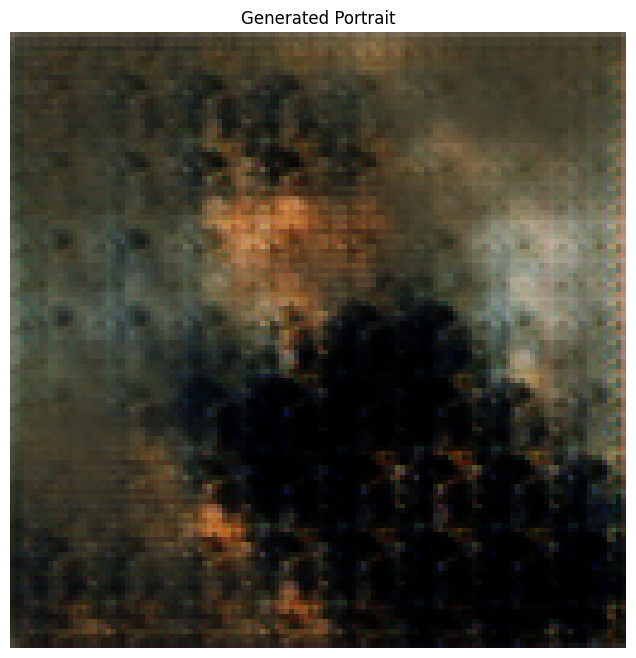

In [26]:
# Generate a sample portrait
print("\nGenerating sample portrait...")
generate_single_portrait(generator, config)